In [ ]:
!git clone https://github.com/MoeMj1019/shortcut-learning-in-CNNs.git
%cd shortcut-learning-in-CNNs
!pwd
!ls

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

from data_preprocessing import *
from models import SimpleCNN, ResNet
from models.utils import TestCallback, SaveModelWeights
from cutout.cutout import DynamicCutoutLayer, RandomCutoutLayer
from cutout.utils import zero_out, zero_out_batched, plot_progress, plot_attention
# from cutout.mult_cutout import CutOut

2024-04-14 20:50:56.395372: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Hyperparameter initialization

In [2]:
BATCH_SIZE = 128
EPOCHS = 2

OPTIMIZER='adam'
LOSS='categorical_crossentropy'

### Load and preprocess data

In [3]:
(train_ds, test_ds), info_ds = tfds.load('cifar10', split=['train', 'test'],
                                          as_supervised=True, with_info=True,
                                          shuffle_files=True)

INFO:absl:Load dataset info from /home/martin/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Reusing dataset cifar10 (/home/martin/tensorflow_datasets/cifar10/3.0.2)
2024-04-14 20:50:58.474100: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
INFO:absl:Constructing tf.data.Dataset cifar10 for split ['train', 'test'], from /home/martin/tensorflow_datasets/cifar10/3.0.2


In [4]:
label_names = info_ds.features['label'].names
print(label_names)
# tfds.show_examples(train_ds, info_ds, rows=1, cols=4)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
rnd_cutout = RandomCutoutLayer(mask_size=10, cutout_prob=1, shape='square')

train_data_rndCutout = train_ds.skip(10000).apply(lambda ds: 
                            prepare_dataset(ds, batch_size=BATCH_SIZE ,kind="train", cutout_layer=rnd_cutout))
train_data_NO_rndCutout = train_ds.skip(10000).apply(lambda ds: 
                            prepare_dataset(ds, batch_size=BATCH_SIZE ,kind="train", cutout_layer=rnd_cutout))
val_data = train_ds.take(10000).apply(lambda ds:
                            prepare_dataset(ds, batch_size=BATCH_SIZE ,kind="val"))
test_data = test_ds.apply(lambda ds:
                          prepare_dataset(ds, batch_size=BATCH_SIZE ,kind="test"))

### Inspection of the data

2024-04-14 20:50:59.457382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2024-04-14 20:50:59.457816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-04-14 20:51:00.606005: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline 

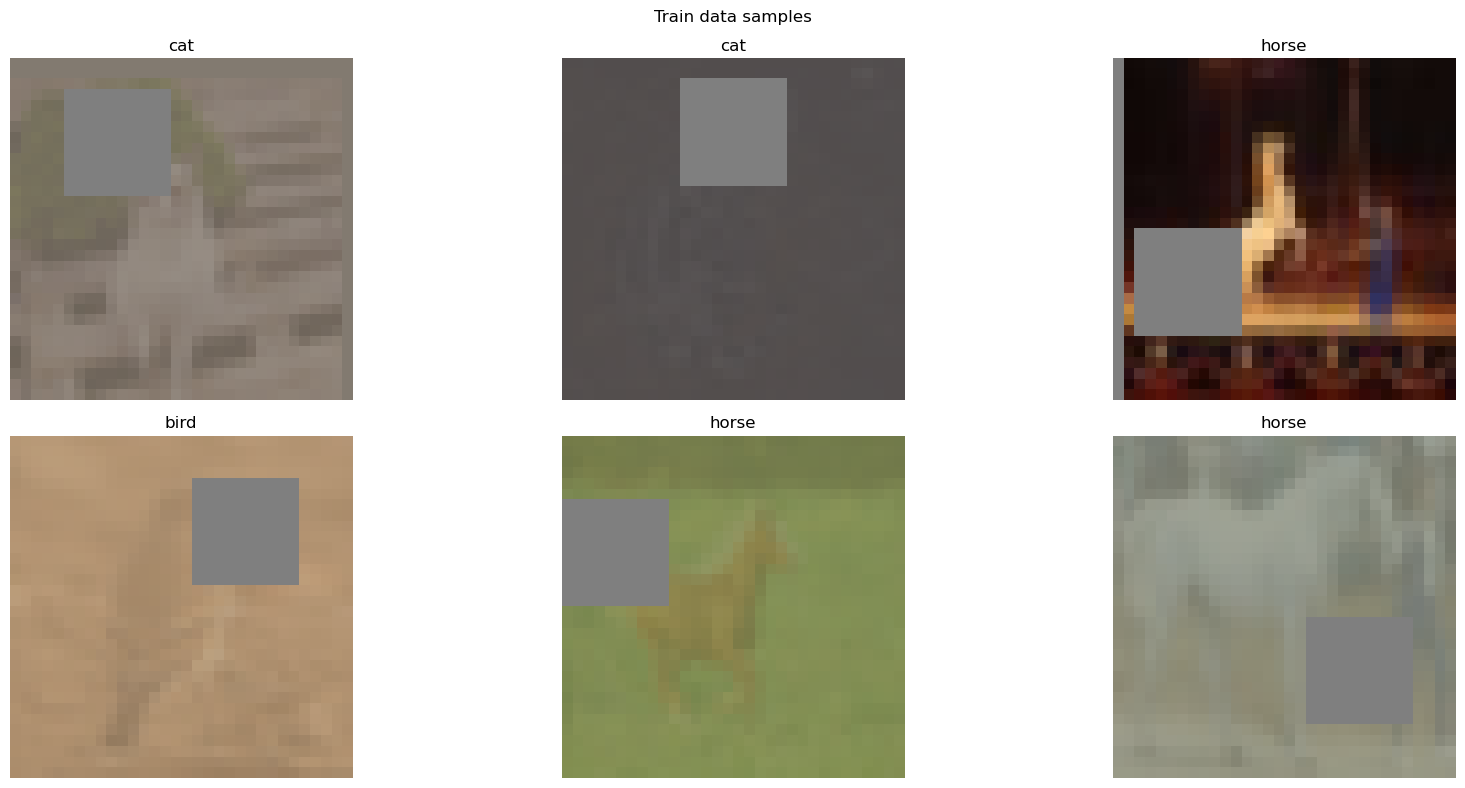

2024-04-14 20:51:00.878724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2024-04-14 20:51:00.879222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


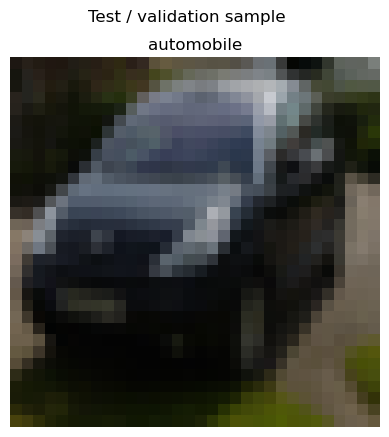

In [6]:
import matplotlib.pyplot as plt

# samples from train data
num_samples = 6
max_plots_per_row = 3  
num_columns = min(num_samples, max_plots_per_row)
num_rows = (num_samples + max_plots_per_row - 1) // max_plots_per_row 
fig_width = num_columns * 6
fig_height = num_rows * 4
# create the subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(fig_width, fig_height))
fig.suptitle('Train data samples')
# flatten the array of axes
# ensure its an array in case of single sample
axes = np.asarray(axes).flatten()

for i, (image, label) in enumerate(train_data_rndCutout.take(num_samples)):
    axes[i].imshow((image[0] + 1) / 2)
    # set the title to the int of the one-hot encoding
    label = label_names[np.argmax(label[0])]
    axes[i].set_title(label)
    axes[i].axis('off')
plt.tight_layout()
plt.show()
# image from test data
img_test, label_test = iter(test_data.take(1)).next()
plt.imshow((img_test[0] + 1) / 2)
plt.suptitle('Test / validation sample')
plt.title(f"{label_names[np.argmax(label_test[0])]}")
plt.axis('off')
plt.show()

### Initialisation of the models

In [7]:
# simple_CNN = SimpleCNN()
# simple_CNN.build((None, 32, 32, 3))  # Necessary to create the model's weights
# simple_CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# # model.summary()

# without dynamic saliency-based cutout
res_net18 = ResNet((32, 32, 3), 10, type='resnet18')
res_net18.build((None, 32, 32, 3))
res_net18.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
res_net18.summary()

# with dynamic saliency-based cutout
res_net18_cutout = ResNet((32, 32, 3), 10, type='resnet18', use_cutout=True)
res_net18_cutout.build((None, 32, 32, 3))
res_net18_cutout.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=['accuracy'])
# res_net18_cutout.summary()

# res_net34 = ResNet((32, 32, 3), 10, type='resnet34')
# res_net34.build((None, 32, 32, 3))
# res_net34.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# # res_net34.summary()

Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dynamic_cutout_layer (Dynam  multiple                 0 (unused)
 icCutoutLayer)                                                  
                                                                 
 model (Functional)          (None, 10)                4923978   
                                                                 
Total params: 4,923,978
Trainable params: 4,918,090
Non-trainable params: 5,888
_________________________________________________________________


### Training of the models

In [8]:
# test with less data
EPOCHS = 4
train_split = train_data_rndCutout.take(10)
train_split_cutout = train_data_NO_rndCutout.take(10)
val_split = val_data.take(1)
test_split = test_data.take(10)
## -----------------------------------------------------------
# test_res_callback_sCNN = TestCallback(test_data=test_split)
test_res_callback_res18 = TestCallback(test_data=test_split)
test_res_callback_res18_cutout = TestCallback(test_data=test_split)

# test_res_callback_res34 = TestCallback(test_data=test_split)

save_weights_callback = SaveModelWeights(n=2, save_path='trained_models/' )

# history_sCNN = simple_CNN.fit(train_split, epochs=EPOCHS, validation_data=val_split, callbacks=[test_res_callback_sCNN, save_weights_callback])
history_res18 = res_net18.fit(train_split, epochs=EPOCHS, validation_data=val_split, 
                              callbacks=[test_res_callback_res18, save_weights_callback])
history_res18_cutout = res_net18_cutout.fit(train_split, epochs=EPOCHS, validation_data=val_split,
                                callbacks=[test_res_callback_res18_cutout, save_weights_callback])
# history_res34 = res_net34.fit(train_split, epochs=EPOCHS, validation_data=val_split, callbacks=[test_res_callback_res34, save_weights_callback])

# Ensure the directory exists and save the model weights
os.makedirs('trained_models', exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S") 
# simple_CNN.save_weights(f'trained_models/simpleCNN_{timestamp}.h5')
res_net18.save_weights(f'trained_models/resnet18_{timestamp}_EP{EPOCHS}.h5')
res_net18_cutout.save_weights(f'trained_models/resnet18_cutout_{timestamp}_EP{EPOCHS}.h5')
# res_net34.save_weights(f'trained_models/resnet34_{timestamp}.h5')

Epoch 1/4


2024-04-14 20:51:02.058334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2024-04-14 20:51:02.058788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


 9/10 [==========================>...] - ETA: 0s - loss: 2.6635 - accuracy: 0.1797

2024-04-14 20:51:10.629465: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - ETA: 0s - loss: 2.6515 - accuracy: 0.1773

2024-04-14 20:51:11.134681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2024-04-14 20:51:11.141681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2024-04-14 20:51:12.033383: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline s

Epoch 0: Testing loss: 2.282648801803589, accuracy: 0.18437500298023224
10/10 [==============================] - 11s 680ms/step - loss: 2.6515 - accuracy: 0.1773 - val_loss: 2.2718 - val_accuracy: 0.2266 - epoch: 0.0000e+00 - test_loss: 2.2826 - test_accuracy: 0.1844
Epoch 2/4
 9/10 [==========================>...] - ETA: 0s - loss: 2.1823 - accuracy: 0.2352

2024-04-14 20:51:18.680312: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - ETA: 0s - loss: 2.1638 - accuracy: 0.2391

2024-04-14 20:51:19.710107: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 1: Testing loss: 2.2099316120147705, accuracy: 0.24453124403953552
10/10 [==============================] - 8s 687ms/step - loss: 2.1638 - accuracy: 0.2391 - val_loss: 2.2425 - val_accuracy: 0.1406 - epoch: 1.0000 - test_loss: 2.2099 - test_accuracy: 0.2445
Epoch 3/4
 9/10 [==========================>...] - ETA: 0s - loss: 2.0311 - accuracy: 0.2804

2024-04-14 20:51:26.150737: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - ETA: 0s - loss: 2.0236 - accuracy: 0.2828

2024-04-14 20:51:27.060728: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 2: Testing loss: 2.176469087600708, accuracy: 0.24140624701976776
10/10 [==============================] - 7s 648ms/step - loss: 2.0236 - accuracy: 0.2828 - val_loss: 2.1642 - val_accuracy: 0.2891 - epoch: 2.0000 - test_loss: 2.1765 - test_accuracy: 0.2414
Epoch 4/4
 9/10 [==========================>...] - ETA: 0s - loss: 1.9923 - accuracy: 0.2535

2024-04-14 20:51:33.539066: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - ETA: 0s - loss: 1.9861 - accuracy: 0.2531

2024-04-14 20:51:34.421328: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 3: Testing loss: 2.1411561965942383, accuracy: 0.23046875
10/10 [==============================] - 7s 651ms/step - loss: 1.9861 - accuracy: 0.2531 - val_loss: 2.1515 - val_accuracy: 0.2188 - epoch: 3.0000 - test_loss: 2.1412 - test_accuracy: 0.2305
Epoch 1/4
 9/10 [==========================>...] - ETA: 0s - loss: 2.6320 - accuracy: 0.1771

2024-04-14 20:51:46.828877: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - ETA: 0s - loss: 2.6216 - accuracy: 0.1742

2024-04-14 20:51:48.060923: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 0: Testing loss: 2.2722482681274414, accuracy: 0.20234374701976776
10/10 [==============================] - 11s 683ms/step - loss: 2.6216 - accuracy: 0.1742 - val_loss: 2.2772 - val_accuracy: 0.1953 - epoch: 0.0000e+00 - test_loss: 2.2722 - test_accuracy: 0.2023
Epoch 2/4
 9/10 [==========================>...] - ETA: 0s - loss: 2.2400 - accuracy: 0.2283

2024-04-14 20:51:54.672953: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - ETA: 0s - loss: 2.2379 - accuracy: 0.2281

2024-04-14 20:51:55.569708: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 1: Testing loss: 2.252406120300293, accuracy: 0.22421875596046448
10/10 [==============================] - 8s 684ms/step - loss: 2.2379 - accuracy: 0.2281 - val_loss: 2.2487 - val_accuracy: 0.2031 - epoch: 1.0000 - test_loss: 2.2524 - test_accuracy: 0.2242
Epoch 3/4
 9/10 [==========================>...] - ETA: 0s - loss: 2.0833 - accuracy: 0.2457

2024-04-14 20:52:02.107431: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - ETA: 0s - loss: 2.0614 - accuracy: 0.2492

2024-04-14 20:52:03.056630: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 2: Testing loss: 2.1778154373168945, accuracy: 0.203125
10/10 [==============================] - 7s 673ms/step - loss: 2.0614 - accuracy: 0.2492 - val_loss: 2.1803 - val_accuracy: 0.2656 - epoch: 2.0000 - test_loss: 2.1778 - test_accuracy: 0.2031
Epoch 4/4
 9/10 [==========================>...] - ETA: 0s - loss: 1.9941 - accuracy: 0.2760

2024-04-14 20:52:09.568572: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - ETA: 0s - loss: 1.9951 - accuracy: 0.2727

2024-04-14 20:52:10.440755: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 3: Testing loss: 2.1244893074035645, accuracy: 0.20156249403953552
10/10 [==============================] - 8s 663ms/step - loss: 1.9951 - accuracy: 0.2727 - val_loss: 2.1505 - val_accuracy: 0.1562 - epoch: 3.0000 - test_loss: 2.1245 - test_accuracy: 0.2016


### Inspection of the training results

In [9]:
# print(history_sCNN.params, history_sCNN.history.keys())
# print(history_sCNN.history['val_accuracy'])

print(history_res18.params, history_res18.history.keys())
print(history_res18.history['val_accuracy'])

print(history_res18_cutout.params, history_res18_cutout.history.keys())
print(history_res18_cutout.history['val_accuracy'])

# print(history_res34.params, history_res34.history.keys())
# print(history_res34.history['val_accuracy'])

{'verbose': 1, 'epochs': 4, 'steps': 10} dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'epoch', 'test_loss', 'test_accuracy'])
[0.2265625, 0.140625, 0.2890625, 0.21875]
{'verbose': 1, 'epochs': 4, 'steps': 10} dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'epoch', 'test_loss', 'test_accuracy'])
[0.1953125, 0.203125, 0.265625, 0.15625]


#### Plotting the results of training, validation and testing

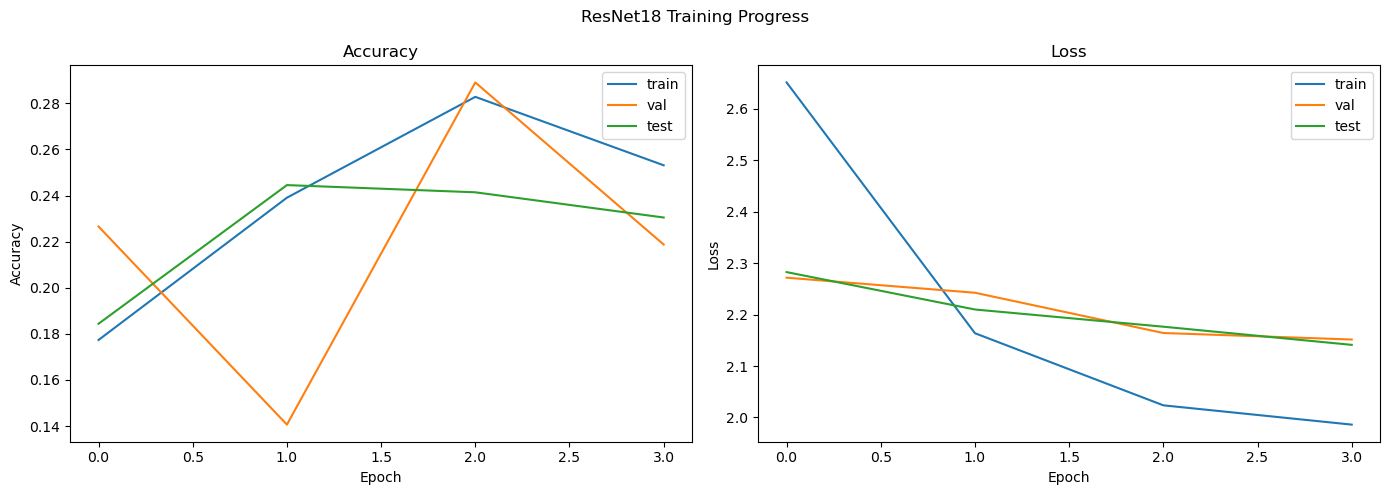

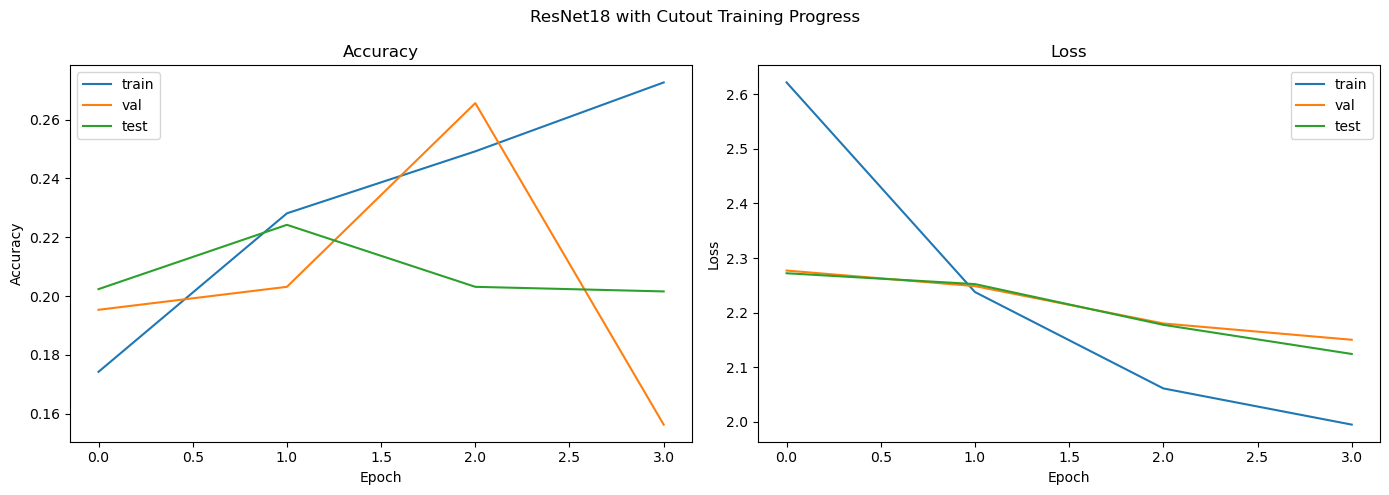

(<Figure size 1400x500 with 2 Axes>,
 array([<Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>,
        <Axes: title={'center': 'Loss'}, xlabel='Epoch', ylabel='Loss'>],
       dtype=object))

In [10]:
plot_progress(history_res18, test_res_callback_res18.test_results, 'ResNet18')
plot_progress(history_res18_cutout, test_res_callback_res18_cutout.test_results, 'ResNet18 with Cutout')

### Visualisation of the cutout method and the attention maps

2024-04-14 20:52:12.519466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2024-04-14 20:52:12.519941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2024-04-14 20:52:13.635942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input' with dtype float and shape [128,32,32,3]
	 [[{{nod

Instructions for updating:
Use fn_output_signature instead


2024-04-14 20:52:14.112316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'cond/input' with dtype float and shape [128,32,32,3]
	 [[{{node cond/input}}]]
Instructions for updating:
Use fn_output_signature instead


4/4 [==============================] - 0s 20ms/step


2024-04-14 20:52:15.086290: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 0s 50ms/step


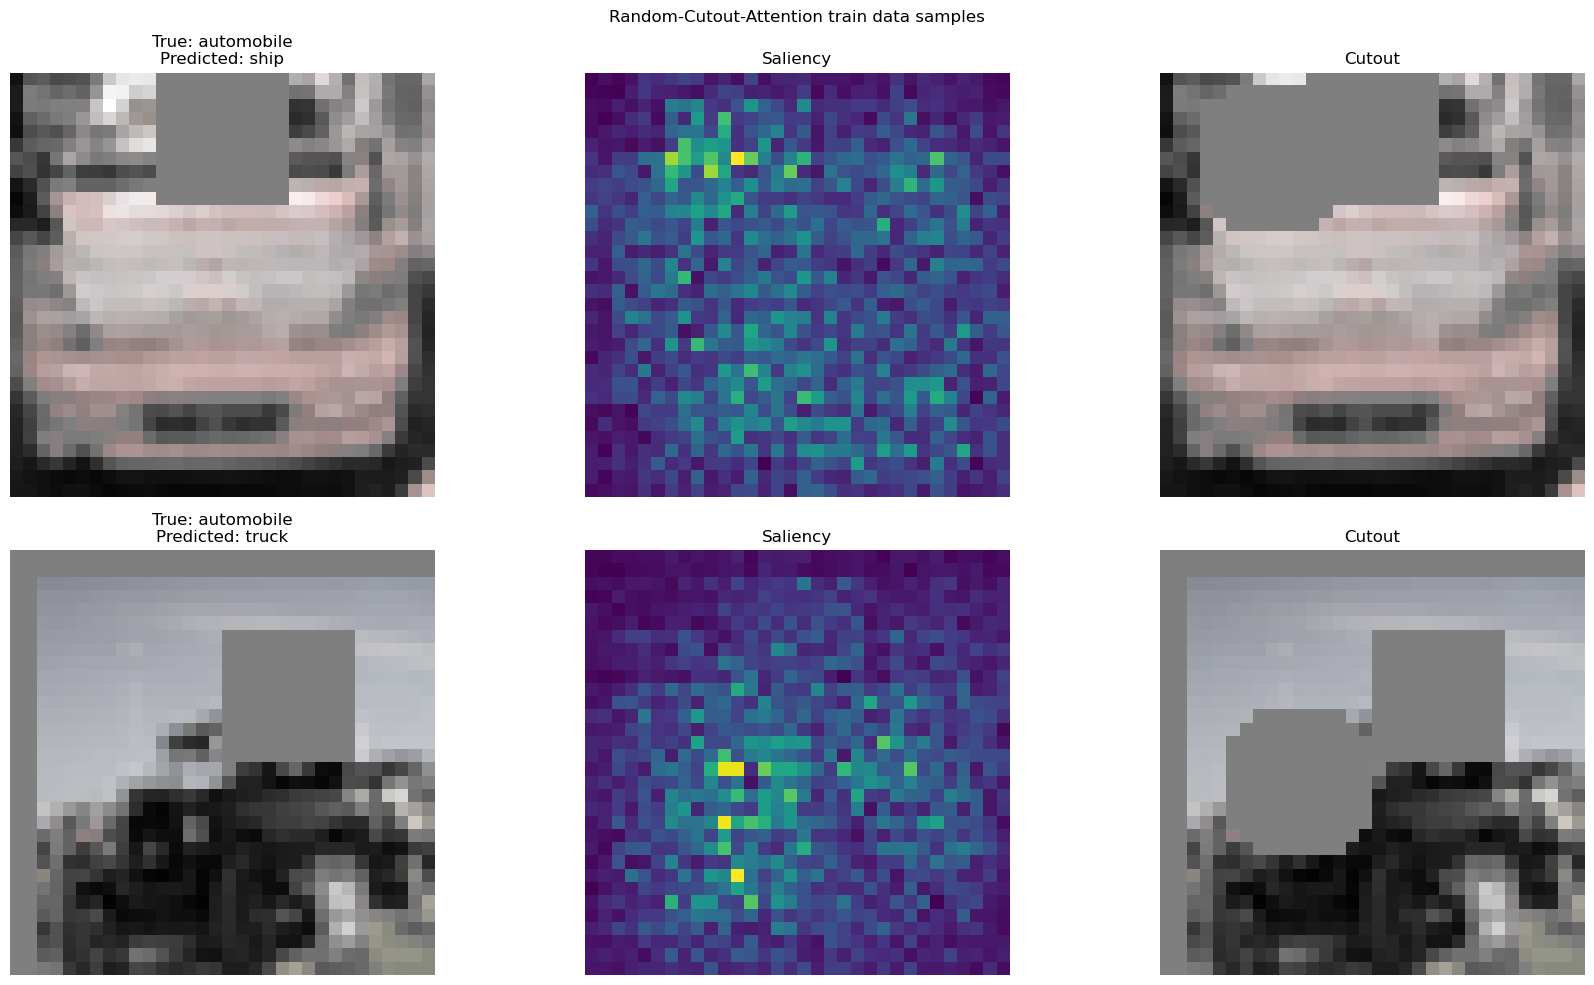

2024-04-14 20:52:16.168732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2024-04-14 20:52:16.169221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


4/4 [==============================] - 0s 18ms/step


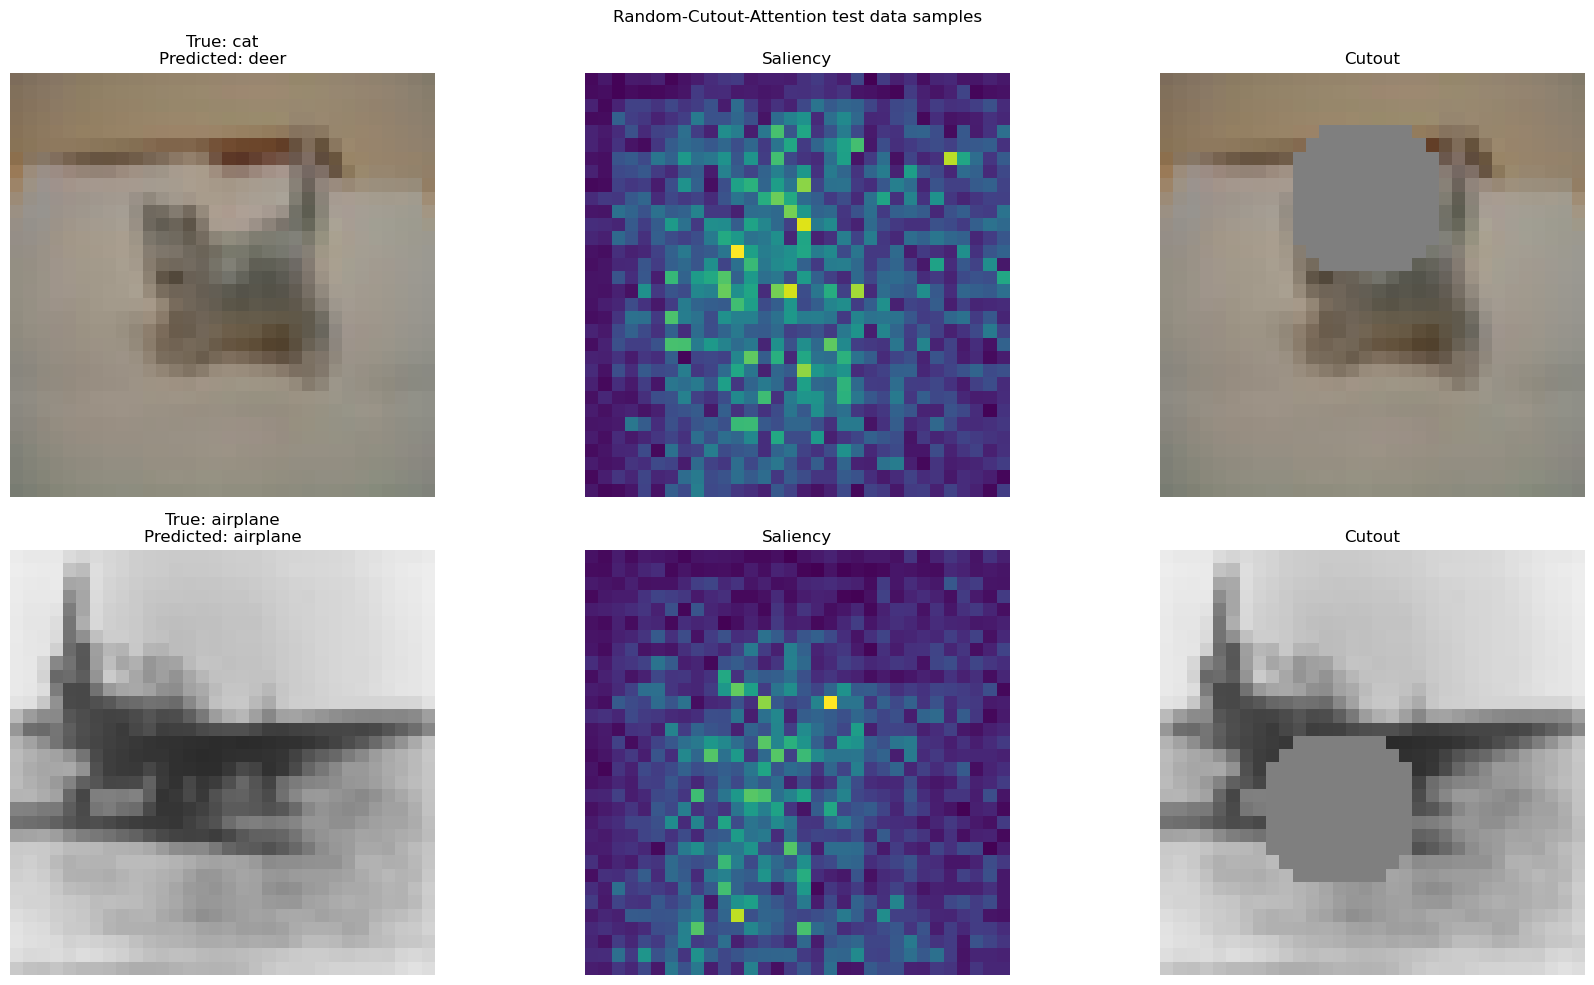

2024-04-14 20:52:17.773871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2024-04-14 20:52:17.774341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2024-04-14 20:52:18.794928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input' with dtype float and shape [128,32,32,3]
	 [[{{nod

4/4 [==============================] - 0s 18ms/step


2024-04-14 20:52:20.163272: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 0s 22ms/step


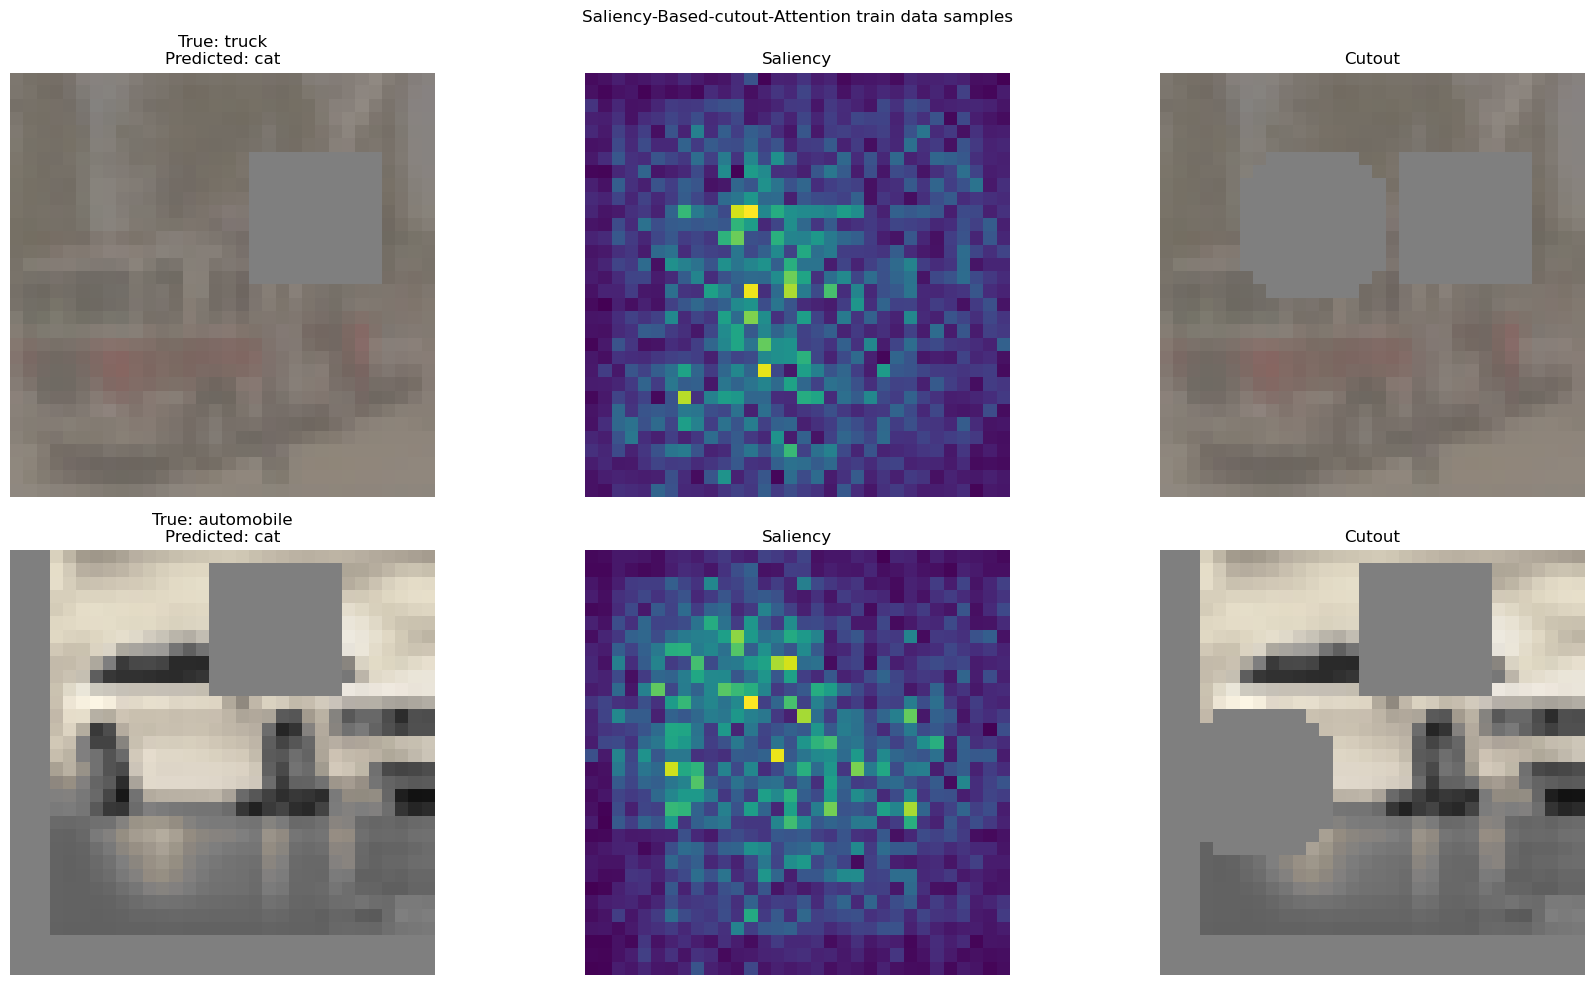

2024-04-14 20:52:21.161325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2024-04-14 20:52:21.161797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


4/4 [==============================] - 0s 27ms/step


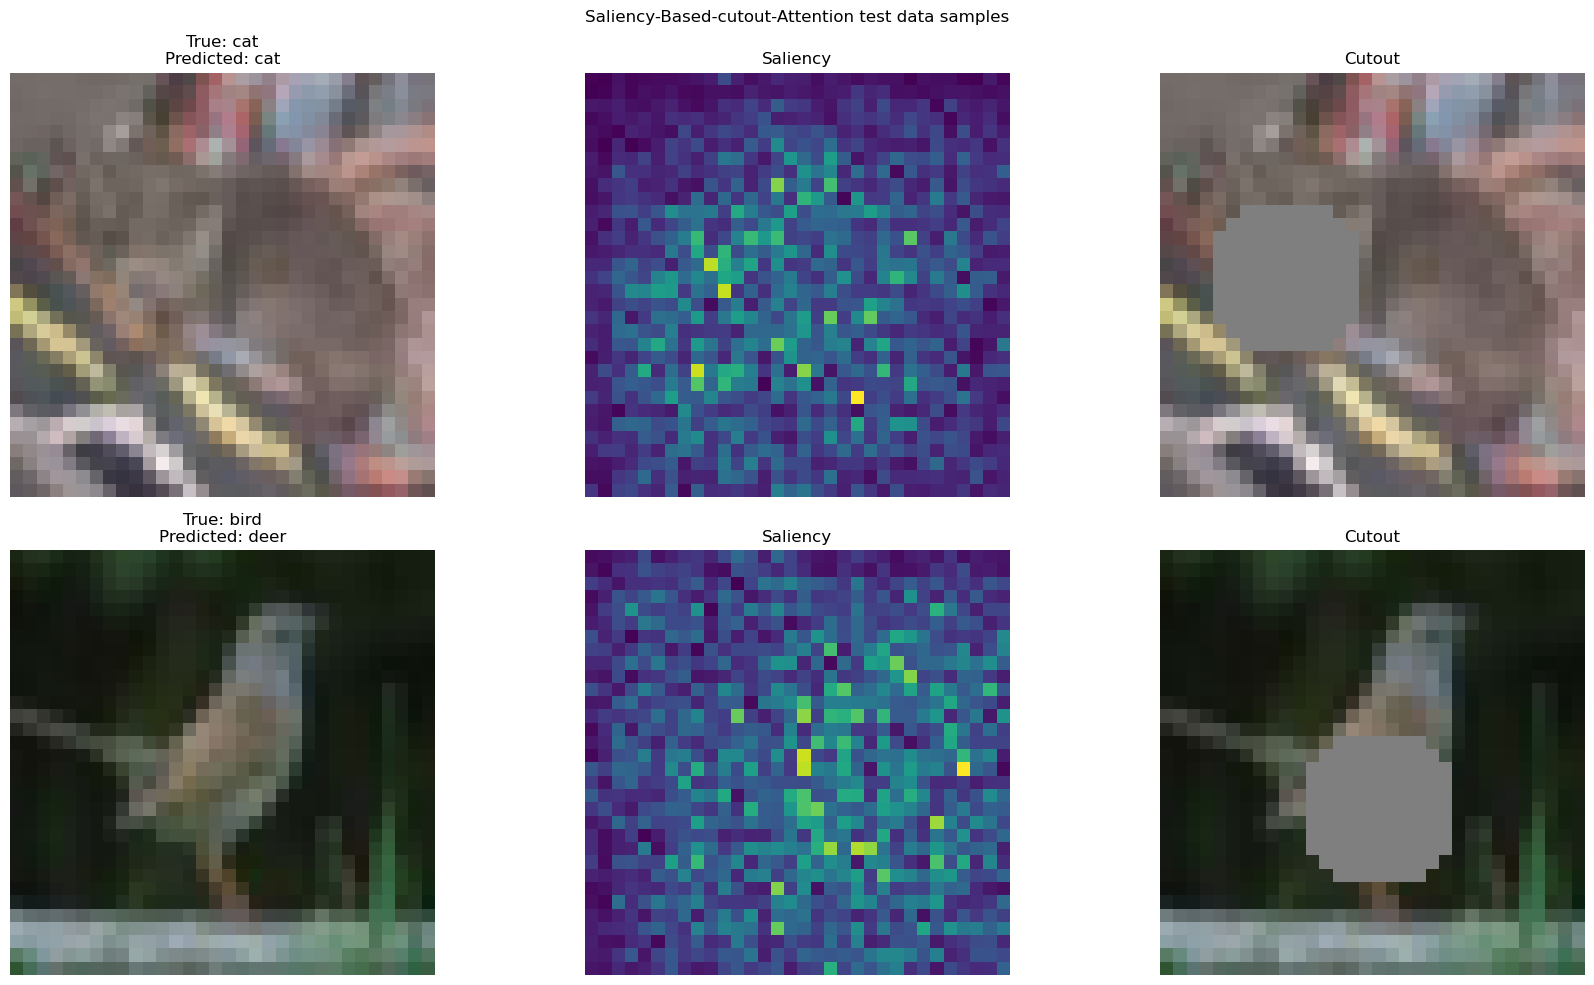

(<Figure size 1800x1000 with 6 Axes>,
 array([<Axes: title={'center': 'True: cat\nPredicted: cat'}>,
        <Axes: title={'center': 'Saliency'}>,
        <Axes: title={'center': 'Cutout'}>,
        <Axes: title={'center': 'True: bird\nPredicted: deer'}>,
        <Axes: title={'center': 'Saliency'}>,
        <Axes: title={'center': 'Cutout'}>], dtype=object))

In [11]:
num_samples = 4
dyn_cutout_layer = DynamicCutoutLayer(mask_size = 12, shape='circle', cutout_prob=1.0)
plot_attention(train_data_rndCutout, res_net18, dyn_cutout_layer, label_names,
               num_samples=num_samples//2, title='Random-Cutout-Attention train data samples')
plot_attention(test_data, res_net18, dyn_cutout_layer, label_names,
               num_samples=num_samples//2 + num_samples%2, title='Random-Cutout-Attention test data samples')

plot_attention(train_data_NO_rndCutout, res_net18_cutout, dyn_cutout_layer, label_names,
               num_samples=num_samples//2, title='Saliency-Based-cutout-Attention train data samples')
plot_attention(test_data, res_net18_cutout, dyn_cutout_layer, label_names,
               num_samples=num_samples//2 + num_samples%2, title='Saliency-Based-cutout-Attention test data samples')